Date: 09.04.2023 \
Author: Reto Hendry

This script is to visualize the results of the parameter sweep.

## libraries and functions

In [32]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
import statsmodels.api as sm

sns.set_theme(style="ticks", palette="pastel")

In [2]:
# function to plot errorbars
def plot_errorbars(x, y, yerr, color, **kwargs):
    plt.errorbar(x, y, yerr=yerr, capsize=2, fmt='none', color=color, **kwargs)

In [3]:
def create_plot(col_var, x_var, x_label, datasets,
                progression_lines=False,):
    """
    Create a plot with the given variables.

    Parameters
    ----------
    col_var : str
        The variable to use for the different subplots.
    x_var : str
        The variable to use for the x-axis.
    x_label : str
        The label for the x-axis.
    progression_lines : bool, optional
        Whether to plot a regression line for the 
        training and test data, by default False.
    datasets : list, optional
        The datasets to use, i.e. [df_tpot, df_pycaret, df_h2o].

    Returns
    -------
    None (plots the figure)
    """

    
    for data in datasets:
        sns.set(style="whitegrid")
        g = sns.FacetGrid(data, col=col_var, height=2.5, aspect=1, col_wrap=4)

        # Training data
        g.map_dataframe(sns.scatterplot, x=x_var, y="CV_Accuracy_(Training)",
                        s=50, color='blue', label="CV_Accuracy_(Training)", alpha=0.5)
        g.map_dataframe(plot_errorbars, x=x_var, y="CV_Accuracy_(Training)",
                        yerr="CV_Std_(Training)", color='blue', label="CV_SD_(Training)", alpha=0.5)
        
        if progression_lines:
            g.map_dataframe(sns.regplot, x=x_var, y="CV_Accuracy_(Training)",
                            scatter=False, color='blue', label="CV_Accuracy_(Training)\nreg. line",
                            line_kws={"lw": 1, "ls": "--"})

        # Test data
        g.map_dataframe(sns.scatterplot, x=x_var, y="Accuracy_(Test)",
                        s=50, color='green', label="Accuracy_(Test)", marker="x", linewidth=1.5)
        if progression_lines:
            g.map_dataframe(sns.regplot, x=x_var, y="Accuracy_(Test)",
                            scatter=False, color='green', label="Accuracy_(Test)\nreg. line",
                            line_kws={"lw": 1, "ls": "--"})

        # Format the plot
        g.set_axis_labels(x_label, "Accuracy")
        g.set(ylim=(0, 1))
        g.add_legend()

        plt.show()

## check for duplicates with same parameters

In [4]:
tool_list = ["tpot", "h2o", "pycaret"]

for tool in tool_list:
    try:
        # analysis only for pycaret
        df = pd.read_csv(f"../results/{tool}_results_df_2xC1.csv")
        df["tool"] = tool

        # Remove duplicates ignoring the "id" field
        subset = list(df.columns)
        subset.remove("id")
        df_no_dup = df.drop_duplicates(subset=subset, keep="first")

        subset = ["component", "resample_cube", "number_of_features", "tool"]
        df_no_param_dup = df.drop_duplicates(subset=subset, keep="first")

        print(f"tool: {tool}",
            f"shape of df before dropping duplicates: {df.shape}",
            f"shape of df after dropping duplicates: {df_no_dup.shape}",
            f"shape of df after dropping parameter duplicates: {df_no_param_dup.shape}",
            sep="\n")

        no_dup_diff = len(df_no_dup) - len(df_no_param_dup)
        print(f"there are {no_dup_diff} models with the same parameters but different results")
    except:
        print(f"!! {tool} not found")
        pass

tool: tpot
shape of df before dropping duplicates: (180, 10)
shape of df after dropping duplicates: (99, 10)
shape of df after dropping parameter duplicates: (90, 10)
there are 9 models with the same parameters but different results
!! h2o not found
tool: pycaret
shape of df before dropping duplicates: (180, 10)
shape of df after dropping duplicates: (90, 10)
shape of df after dropping parameter duplicates: (90, 10)
there are 0 models with the same parameters but different results


## Load results, concatenate, drop duplicates

In [5]:
# create a big dataframe with all the results from all autoML tools
tool_list = ["tpot_results_df.csv", "h2o_results_df.csv", "pycaret_results_df.csv"]

df = pd.DataFrame()

for tool in tool_list:
    df_i = pd.read_csv(f"../results/{tool}")
    df_i["tool"] = tool.split("_")[0]
    df = pd.concat([df_i, df])

In [6]:
# Remove duplicates ignoring the "id" field
subset = list(df.columns)
subset.remove("id")
df_no_dup = df.drop_duplicates(subset=subset, keep="first")

subset = ["component", "resample_cube", "number_of_features", "tool"]
df_no_param_dup = df.drop_duplicates(subset=subset, keep="first")

print(f"shape of df before dropping duplicates: {df.shape}",
      f"shape of df after dropping duplicates: {df_no_dup.shape}",
      f"shape of df after dropping parameter duplicates: {df_no_param_dup.shape}",
      sep="\n")

no_dup_diff = len(df_no_dup) - len(df_no_param_dup)
print(f"there are {no_dup_diff} models with the same parameters but different results")

shape of df before dropping duplicates: (278, 10)
shape of df after dropping duplicates: (244, 10)
shape of df after dropping parameter duplicates: (242, 10)
there are 2 models with the same parameters but different results


## EDA

In [7]:
list(df_no_dup.columns)

['id',
 'component',
 'resample_cube',
 'number_of_features',
 'CV_Accuracy_(Training)',
 'CV_Std_(Training)',
 'Accuracy_(Test)',
 'F1_Score_(Test)',
 'Precision_Score_(Test)',
 'tool']

In [8]:
df_no_param_dup.describe()

,component,resample_cube,number_of_features,CV_Accuracy_(Training),CV_Std_(Training),Accuracy_(Test),F1_Score_(Test),Precision_Score_(Test)
count,242.0,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,1.0,7.454545,110.000000,0.782033,0.144388,0.637747,0.620862,0.654653
std,0.0,4.396339,63.376632,0.067139,0.045997,0.115094,0.127641,0.128948
min,1.0,1.000000,10.000000,0.611100,0.039300,0.388900,0.333300,0.250000
25%,1.0,3.000000,50.000000,0.736100,0.114500,0.555600,0.534825,0.569200
50%,1.0,7.000000,110.000000,0.777800,0.137500,0.611100,0.600000,0.660700
75%,1.0,11.000000,170.000000,0.833300,0.166700,0.722200,0.714300,0.743750
max,1.0,15.000000,210.000000,0.944400,0.299700,0.944400,0.944300,0.950000


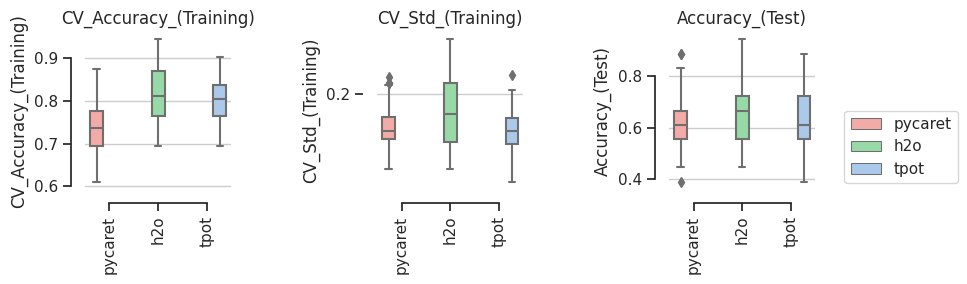

In [9]:
plot_columns = ["CV_Accuracy_(Training)", "CV_Std_(Training)", "Accuracy_(Test)"]

num_columns = len(plot_columns)
num_rows = 1
num_cols = int(np.ceil(num_columns / num_rows))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 3))

# Flatten the axes array to make it easier to loop through
flat_axes = axes.flatten()

for i, col in enumerate(plot_columns):
    sns.boxplot(data=df_no_param_dup, y=col, x="tool",
                hue="tool", palette=["r", "g", "b"],
                ax=flat_axes[i])
    flat_axes[i].set_title(col)
    flat_axes[i].yaxis.grid(True)
    # flat_axes[i].set_ylim(0, 1)
    sns.despine(offset=10, trim=True)
    
    # Remove the legend for all subplots except the last one
    if i != num_columns - 1:
        flat_axes[i].get_legend().remove()
    else:
        # Place the legend outside the last subplot on the right side
        flat_axes[i].legend(bbox_to_anchor=(1.2, 0.5), loc='upper left', borderaxespad=0.)

    flat_axes[i].set_xlabel("")
    flat_axes[i].tick_params(axis='x', rotation=90)


# Remove any unused axes
for j in range(i+1, num_rows * num_cols):
    flat_axes[j].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(wspace=1)
plt.show()

## Analysis of best parameters

In [10]:
# create single dataframes for every tool
df_tpot = df_no_param_dup.loc[df_no_param_dup["tool"] == "tpot"]
df_h2o = df_no_param_dup.loc[df_no_param_dup["tool"] == "h2o"]
df_pycaret = df_no_param_dup.loc[df_no_param_dup["tool"] == "pycaret"]

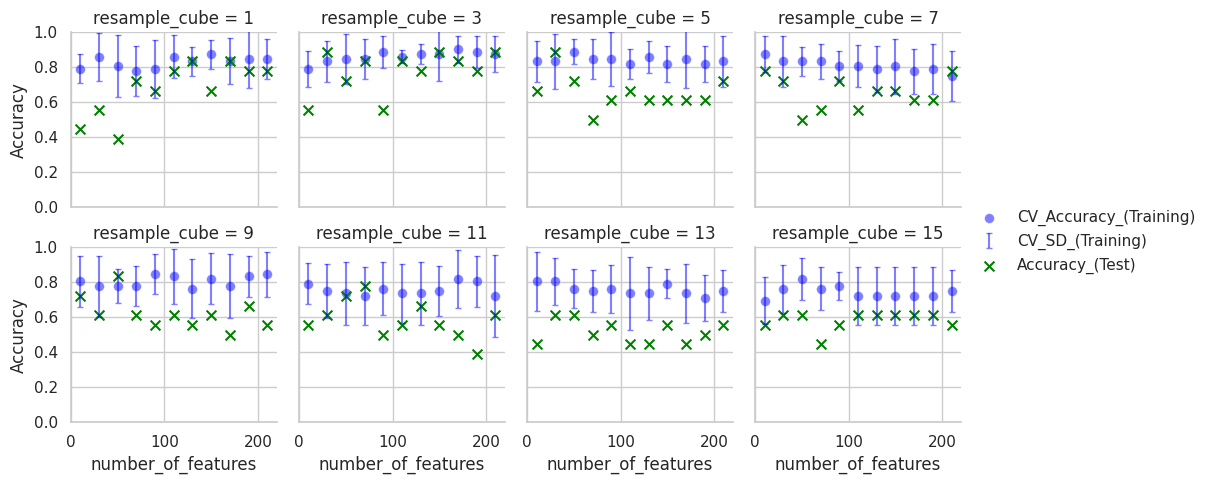

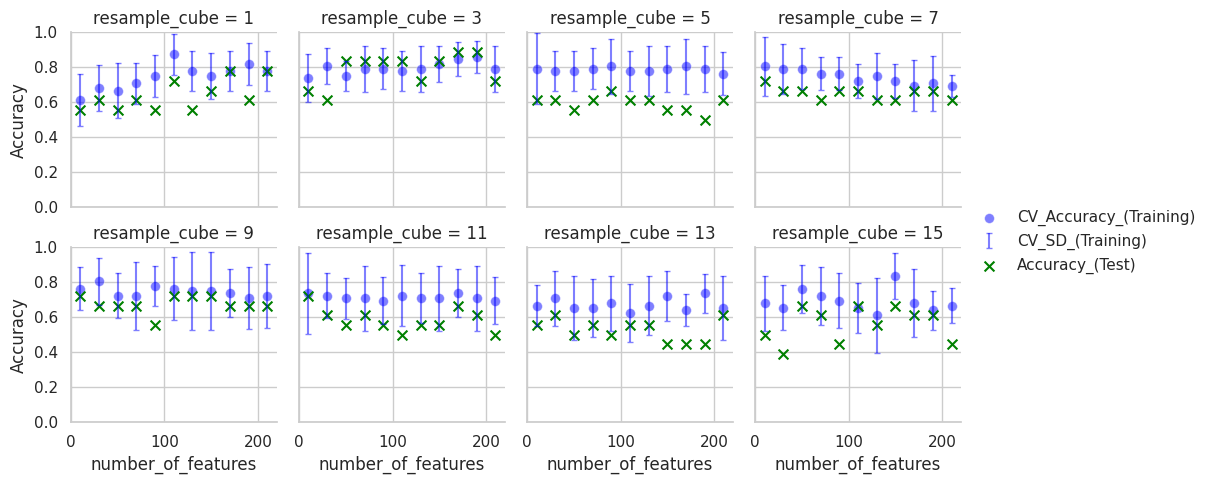

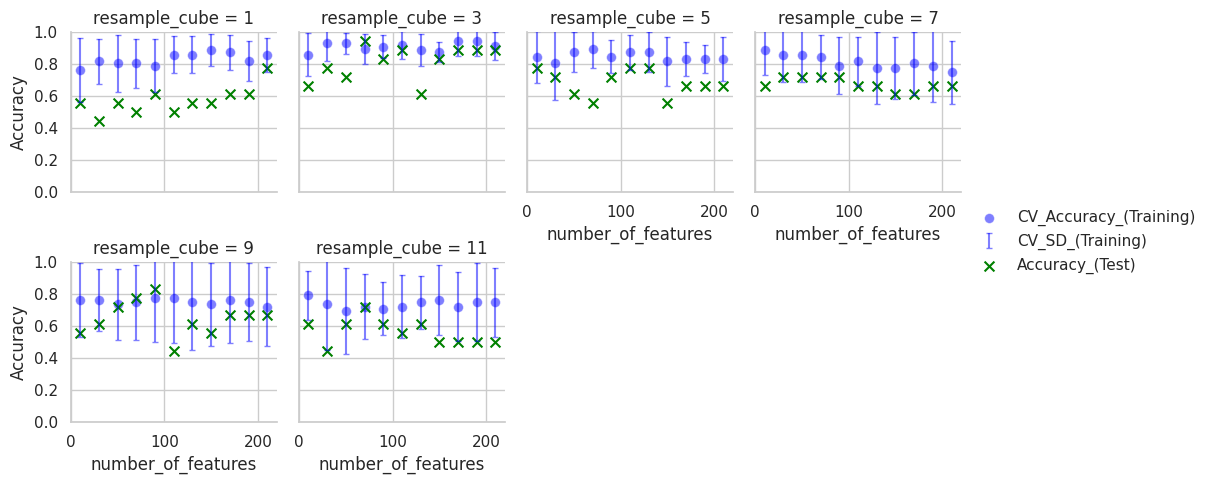

In [11]:
create_plot(col_var="resample_cube", x_var="number_of_features", 
            x_label="number_of_features", datasets=[df_tpot, df_pycaret, df_h2o])


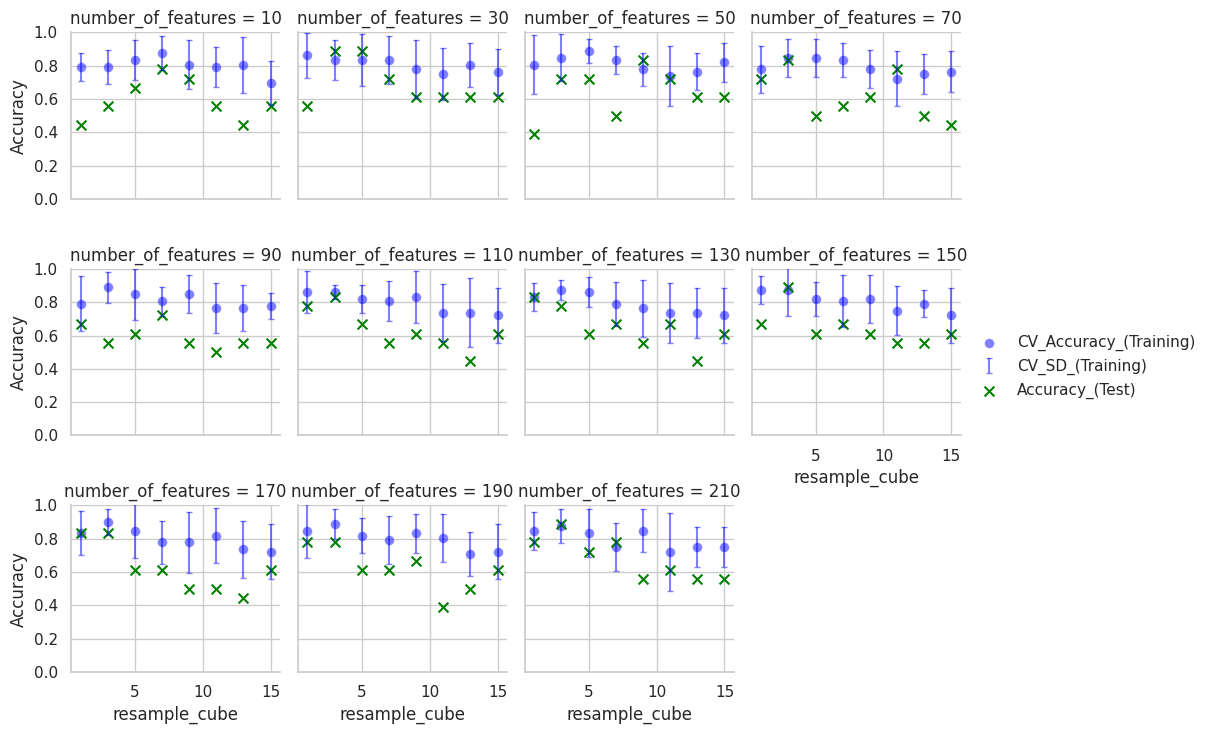

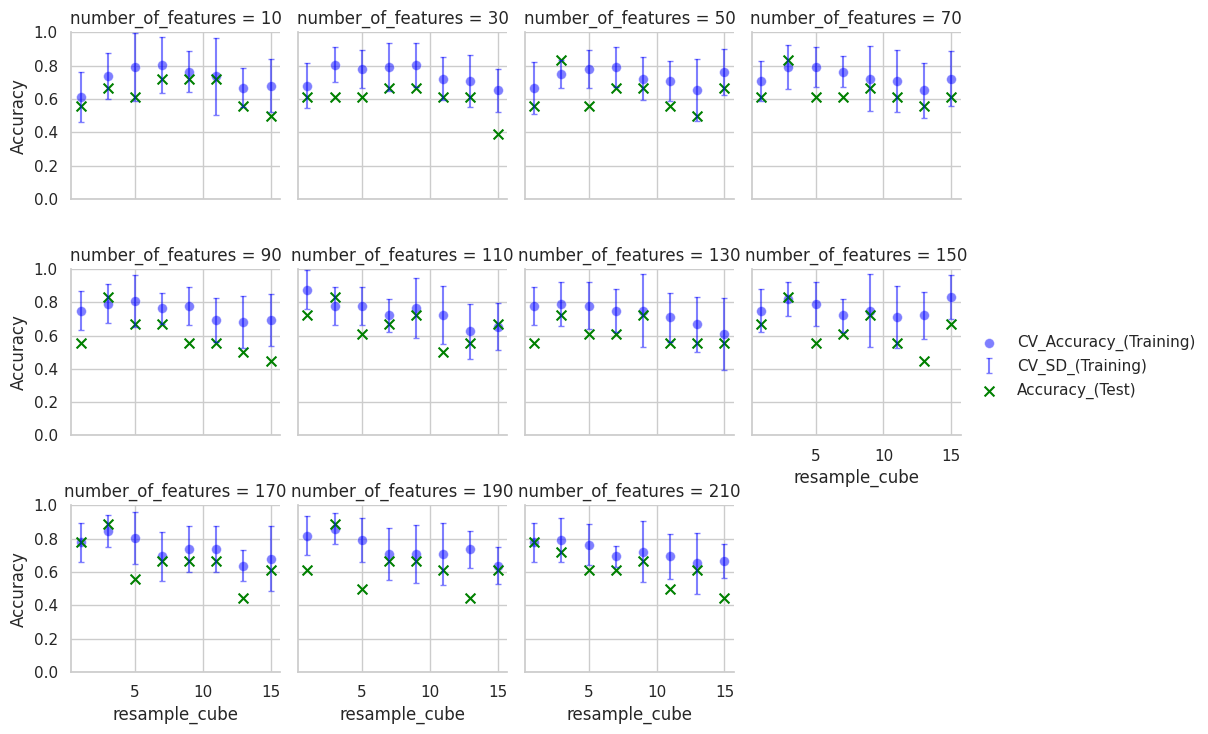

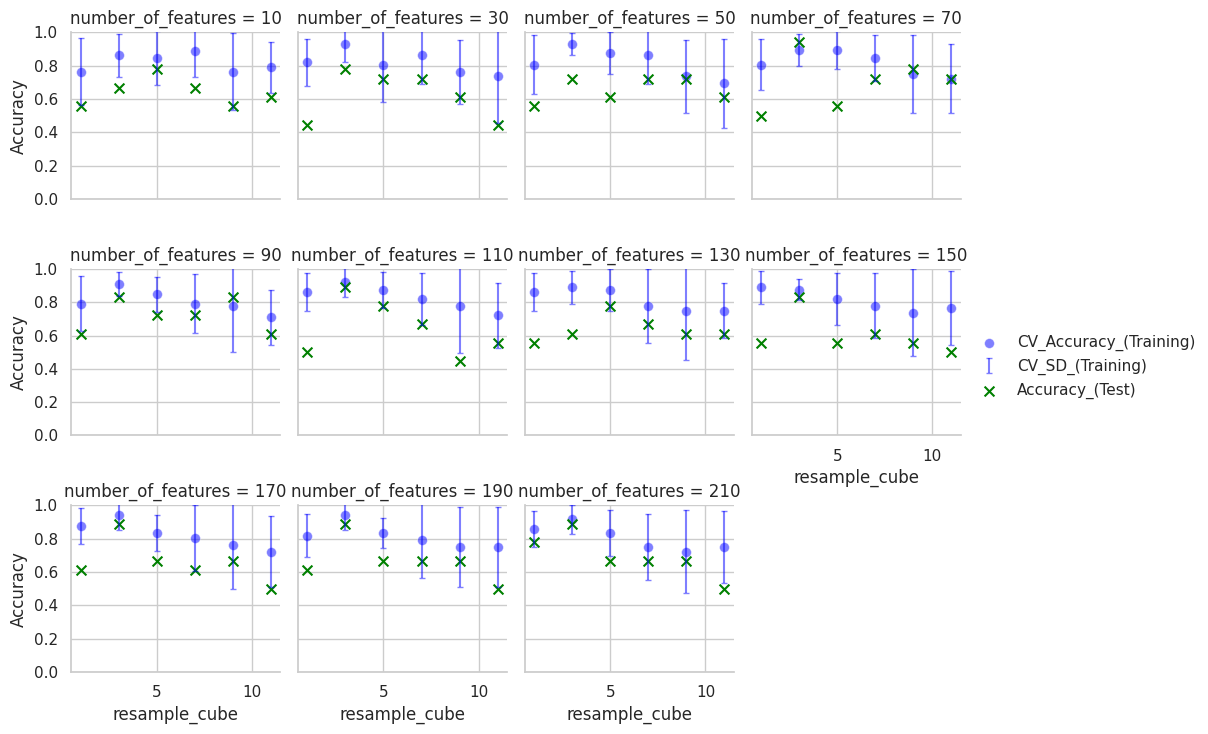

In [12]:
create_plot(col_var="number_of_features", x_var="resample_cube", 
            x_label="resample_cube", datasets=[df_tpot, df_pycaret, df_h2o])


## 3d plots

Top 1: number_of_features = 30, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 2: number_of_features = 150, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 3: number_of_features = 210, resample_cube = 3, Accuracy_(Test) = 0.8889


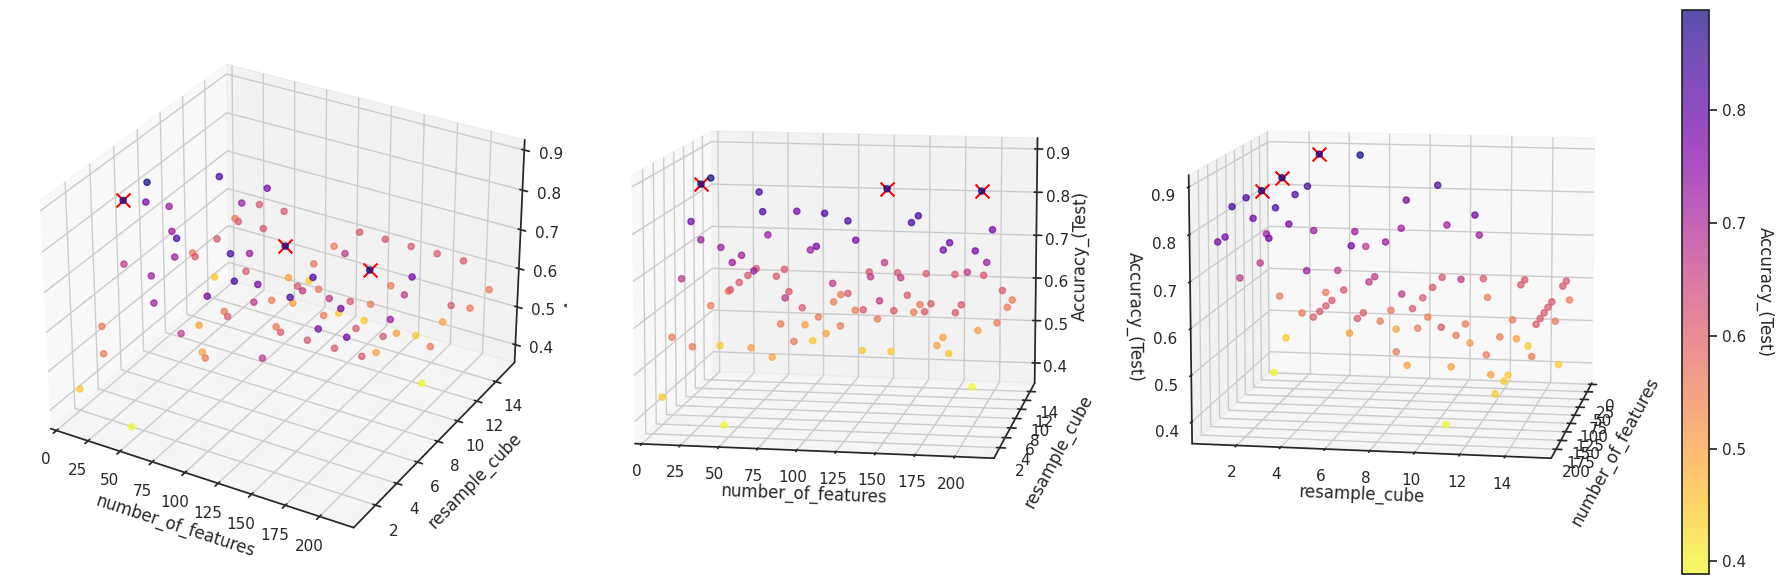

Top 1: number_of_features = 170, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 2: number_of_features = 190, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 3: number_of_features = 50, resample_cube = 3, Accuracy_(Test) = 0.8333


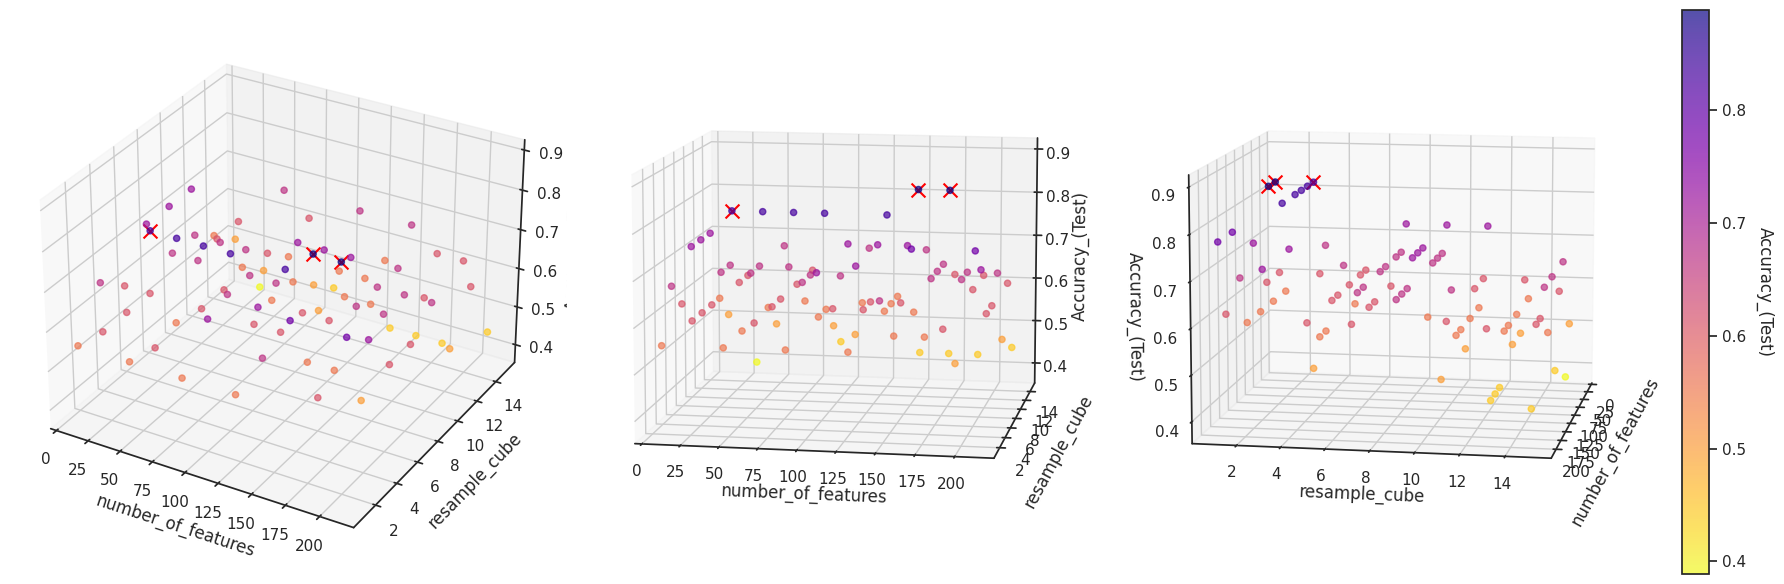

Top 1: number_of_features = 70, resample_cube = 3, Accuracy_(Test) = 0.9444
Top 2: number_of_features = 110, resample_cube = 3, Accuracy_(Test) = 0.8889
Top 3: number_of_features = 170, resample_cube = 3, Accuracy_(Test) = 0.8889


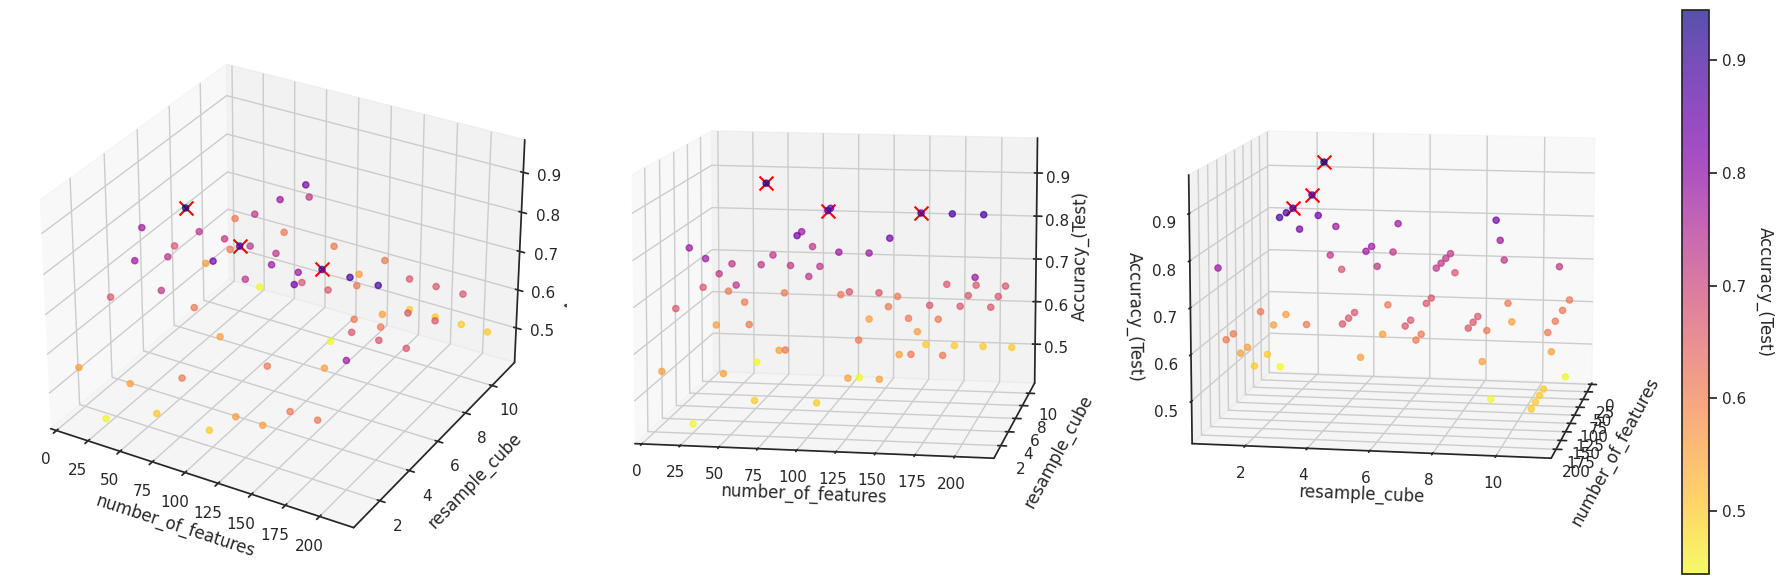

In [41]:
for df in [df_tpot, df_pycaret, df_h2o]:

    # Extract the x, y, and z values from the df DataFrame
    x = df['number_of_features']
    y = df['resample_cube']
    z = df['Accuracy_(Test)']

    # Find the top 3 maximum Accuracy_(Test) values and their corresponding x, y, and z coordinates
    top_3_indexes = z.nlargest(3).index
    top_3_coordinates = [(x[i], y[i], z[i]) for i in top_3_indexes]

    # Print the best parameters and the maximum accuracy for the top 3
    for i, (x_value, y_value, z_value) in enumerate(top_3_coordinates, start=1):
        print(f"Top {i}: number_of_features = {x_value}, resample_cube = {y_value}, Accuracy_(Test) = {z_value}")

    # Create the figure
    fig = plt.figure(figsize=(18, 6))
    gs = gridspec.GridSpec(1, 4, width_ratios=[2, 2, 2, 0.1])

    # First subplot (3D view)
    ax1 = fig.add_subplot(gs[0], projection='3d')
    scatter1 = ax1.scatter(x, y, z, c=z, cmap='plasma_r', alpha=0.7)
    for x_value, y_value, z_value in top_3_coordinates:
        ax1.scatter(x_value, y_value, z_value, c='red', marker='x', s=100)

    # Second subplot (projection along the z-axis)
    ax2 = fig.add_subplot(gs[1], projection='3d')
    scatter2 = ax2.scatter(x, y, z, c=z, cmap='plasma_r', alpha=0.7)
    ax2.view_init(elev=10, azim=-80)  # Change the view angle
    for x_value, y_value, z_value in top_3_coordinates:
        ax2.scatter(x_value, y_value, z_value, c='red', marker='x', s=100)

    # Third subplot (projection along the y-axis)
    ax3 = fig.add_subplot(gs[2], projection='3d')
    scatter3 = ax3.scatter(x, y, z, c=z, cmap='plasma_r', alpha=0.7)
    ax3.view_init(elev=10, azim=10)  # Change the view angle
    for x_value, y_value, z_value in top_3_coordinates:
        ax3.scatter(x_value, y_value, z_value, c='red', marker='x', s=100)

    # Add axis labels
    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel('number_of_features')
        ax.set_ylabel('resample_cube')
        ax.set_zlabel('Accuracy_(Test)')

    # Add a colorbar
    cbar_ax = fig.add_subplot(gs[3])
    cbar = fig.colorbar(scatter1, cax=cbar_ax)
    cbar.set_label('Accuracy_(Test)', rotation=270, labelpad=20)

    # Apply tight_layout
    plt.tight_layout()

    plt.show()

# TODO: eventually reverse the axis so that the points are more visible 
# TODO: add a mean surface to the plot